KAGGLE: https://www.kaggle.com/code/irinaabdullaeva/text-segmentation/notebook

## Overview

This notebook is a first part of full **Offline Handwritten Text Recognition**.     
See full system on Github: https://github.com/IrinaArmstrong/HandwrittenTextRecognition

**Offline Handwritten Text Recognition (HTR)** systems transcribe text contained in scanned images into digital text.             
In this case, the system is developed to deal with cyrillic alphabet. It also involves full dictionary of the Russian language.

In general, developed HTR consists of several parts, which are responsible for processing pages with full text (scanned or photographed), dividing them into lines, splitting the resulting lines into words and following recognition of words from them.

For solve the problem of recognition, it was decided to use Neural Network (NN). It consists of convolutional NN (CNN) layers, recurrent NN (RNN) layers and a final Connectionist Temporal Classification (CTC) layer.

But in this notebook only the task of page segmentation is highlighted. It was decided to do this in several different ways shown below.

### Imports

In [1]:
import cv2
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

In [8]:

import os
#print(os.listdir("./sablon_form"))
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize' : (22, 10)})
sns.set_style("darkgrid", {'axes.grid' : True})

In [11]:
def showImg(img, cmap=None):
    plt.imshow(img, cmap=cmap, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

# Method #1.    
Implementation of scale space technique for word segmentation as proposed by R. Manmatha and N. Srimal. Even though the paper is from 1999, the method still achieves good results, is fast, and is easy to implement. The algorithm takes an image of a line as input and outputs the segmented words.

Scale space technique for word segmentation proposed by R. Manmatha: http://ciir.cs.umass.edu/pubfiles/mm-27.pdf

## Text #1

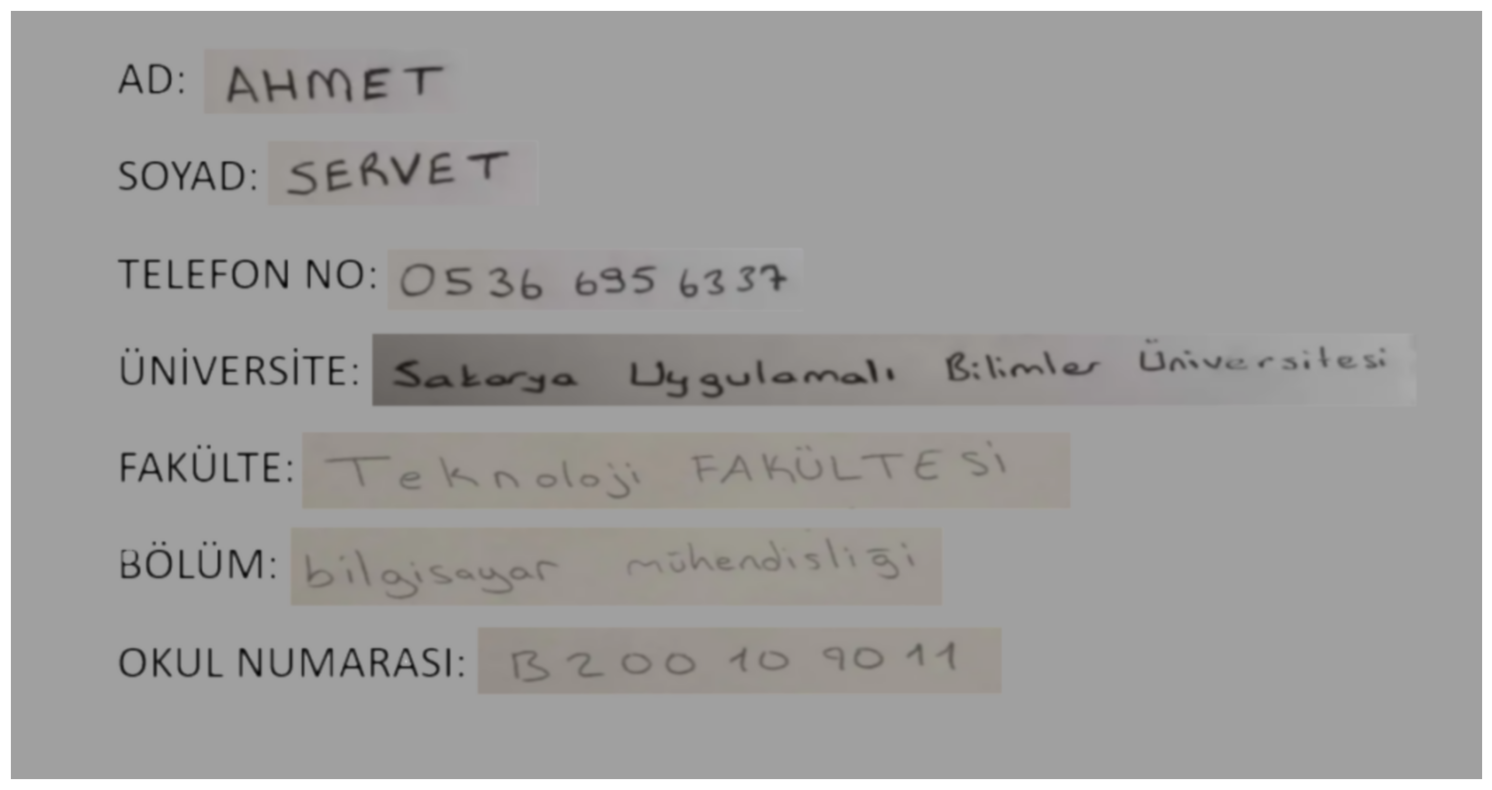

In [36]:
# read image, prepare it by resizing it to fixed height and converting it to grayscale
# img1 = cv2.imread("./sablon_form/form_sablon3.png", cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread("form_sablon4.png")

if img1 is None:
    print("Dosya okunamadı. Lütfen dosyanın mevcut olduğundan ve uygun bir görüntü formatında olduğundan emin olun.")
else:
    img1 = img1.astype(np.uint8)
showImg(img1, cmap='gray')
# plt.imshow(img1)

In [37]:
print(img1.ndim)
print(img1.shape)

3
(549, 1050, 3)


In [38]:
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
print(img2.shape)

(549, 1050)


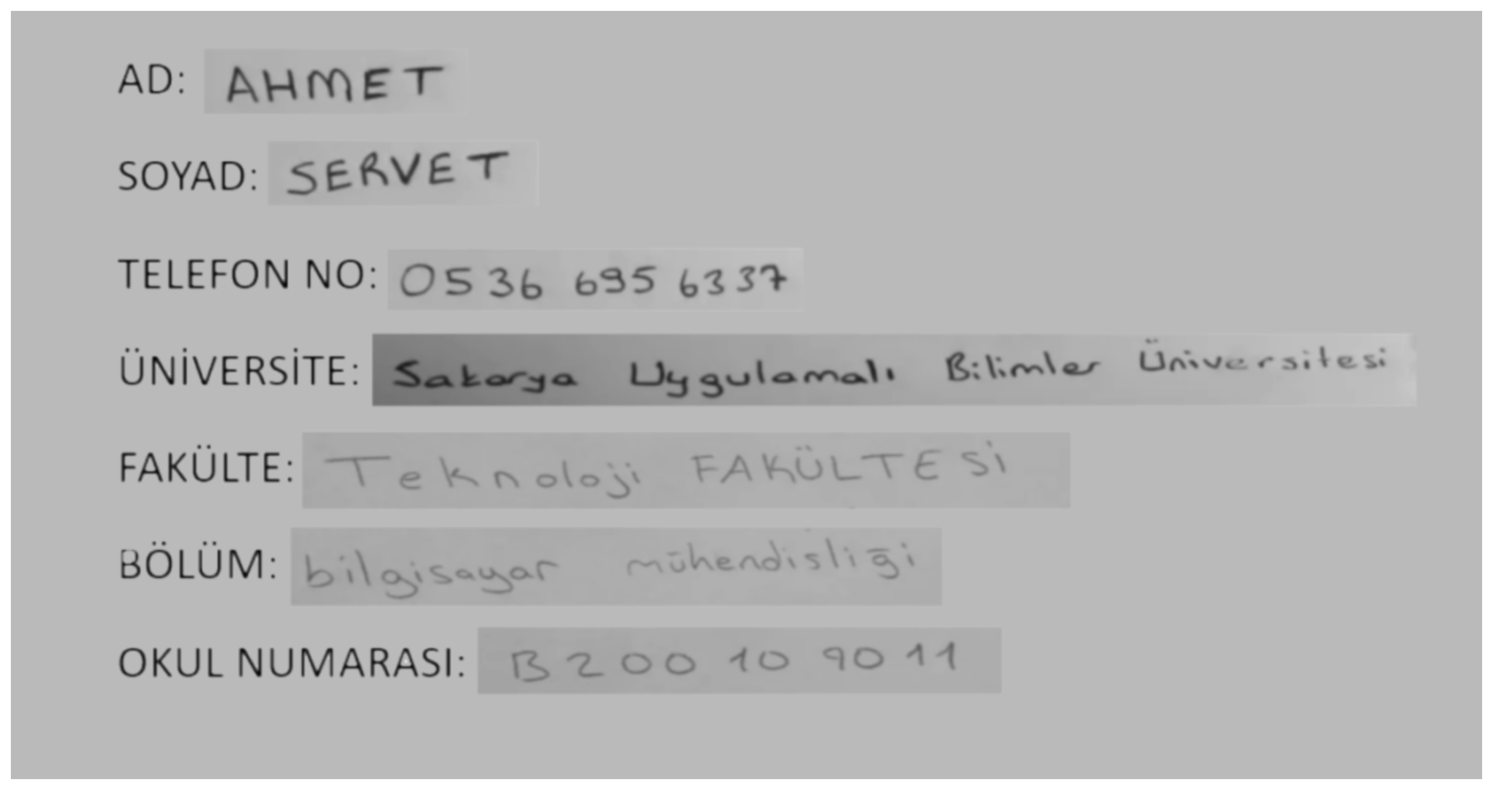

In [39]:
showImg(img2, cmap='gray')

In [40]:
type(img2)

numpy.ndarray

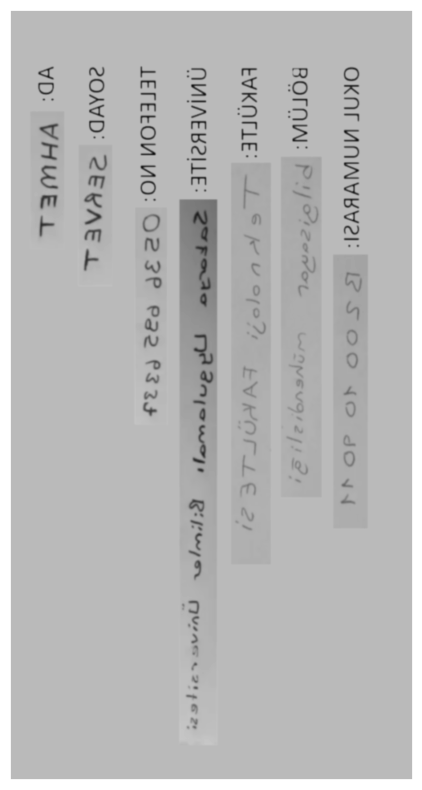

In [41]:
img3 = np.transpose(img2)
showImg(img3, cmap='gray')

In [42]:
img = np.arange(16).reshape((4,4))
img

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

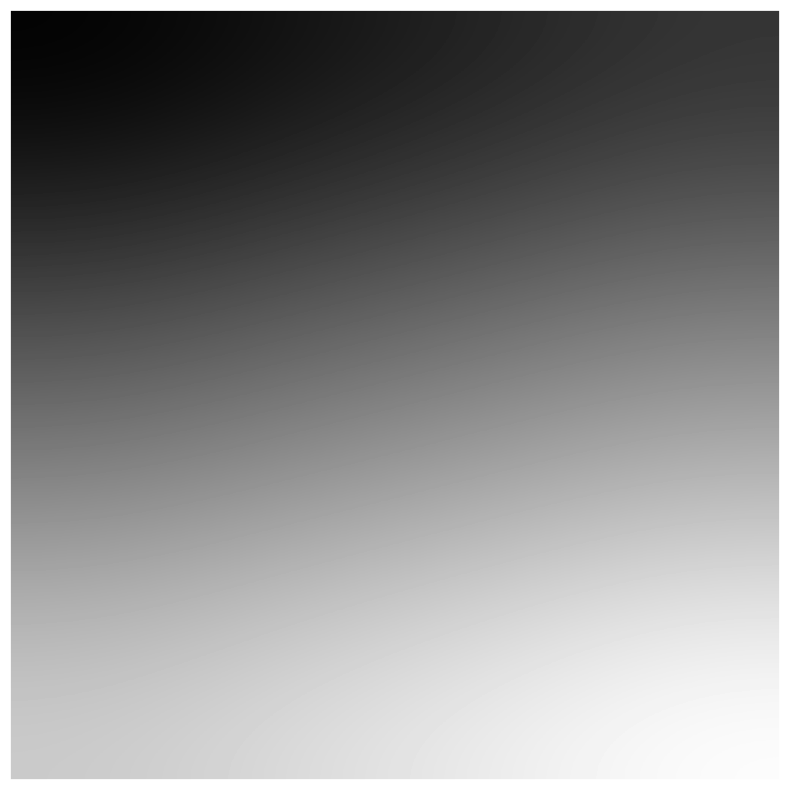

In [43]:
showImg(img, cmap='gray')

In [44]:
def createKernel(kernelSize, sigma, theta):
    "create anisotropic filter kernel according to given parameters"
    assert kernelSize % 2 # must be odd size
    halfSize = kernelSize // 2

    kernel = np.zeros([kernelSize, kernelSize])
    sigmaX = sigma
    sigmaY = sigma * theta

    for i in range(kernelSize):
        for j in range(kernelSize):
            x = i - halfSize
            y = j - halfSize

            expTerm = np.exp(-x**2 / (2 * sigmaX) - y**2 / (2 * sigmaY))
            xTerm = (x**2 - sigmaX**2) / (2 * math.pi * sigmaX**5 * sigmaY)
            yTerm = (y**2 - sigmaY**2) / (2 * math.pi * sigmaY**5 * sigmaX)

            kernel[i, j] = (xTerm + yTerm) * expTerm

    kernel = kernel / np.sum(kernel)
    return kernel

In [45]:
kernelSize=9
sigma=4
theta=1.5
#25, 0.8, 3.5

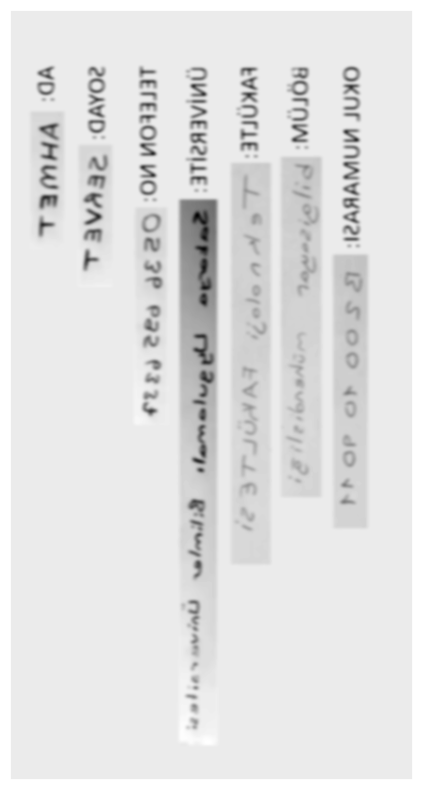

In [46]:
imgFiltered1 = cv2.filter2D(img3, -1, createKernel(kernelSize, sigma, theta), borderType=cv2.BORDER_REPLICATE)
showImg(imgFiltered1, cmap='gray')

In [47]:
def applySummFunctin(img):
    res = np.sum(img, axis = 0)    #  summ elements in columns
    return res

In [48]:
def normalize(img):
    (m, s) = cv2.meanStdDev(img)
    m = m[0][0]
    s = s[0][0]
    img = img - m
    img = img / s if s>0 else img
    return img

In [49]:
img4 = normalize(imgFiltered1)

In [50]:
(m, s) = cv2.meanStdDev(imgFiltered1)
m[0][0]

154.43510451903896

In [51]:
summ = applySummFunctin(img4)
print(summ.ndim)
print(summ.shape)

1
(549,)


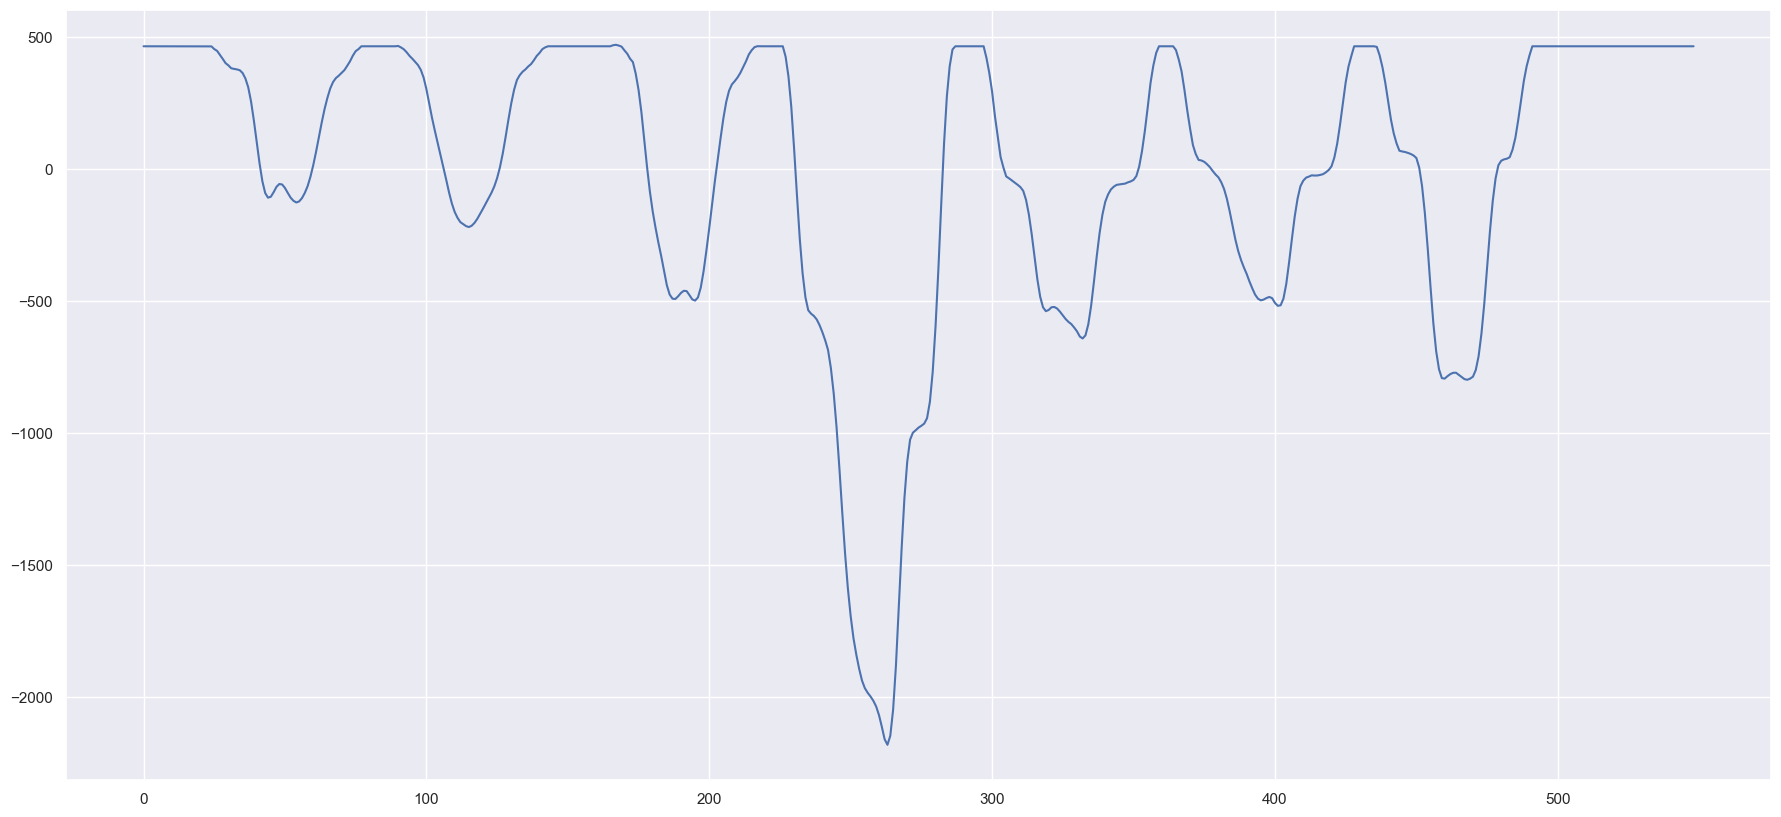

In [52]:
plt.plot(summ)
plt.show()

In [53]:
def smooth(x, window_len=11, window='hanning'):
#     if x.ndim != 1:
#         raise ValueError("smooth only accepts 1 dimension arrays.") 
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.") 
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'") 
    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')
    return y

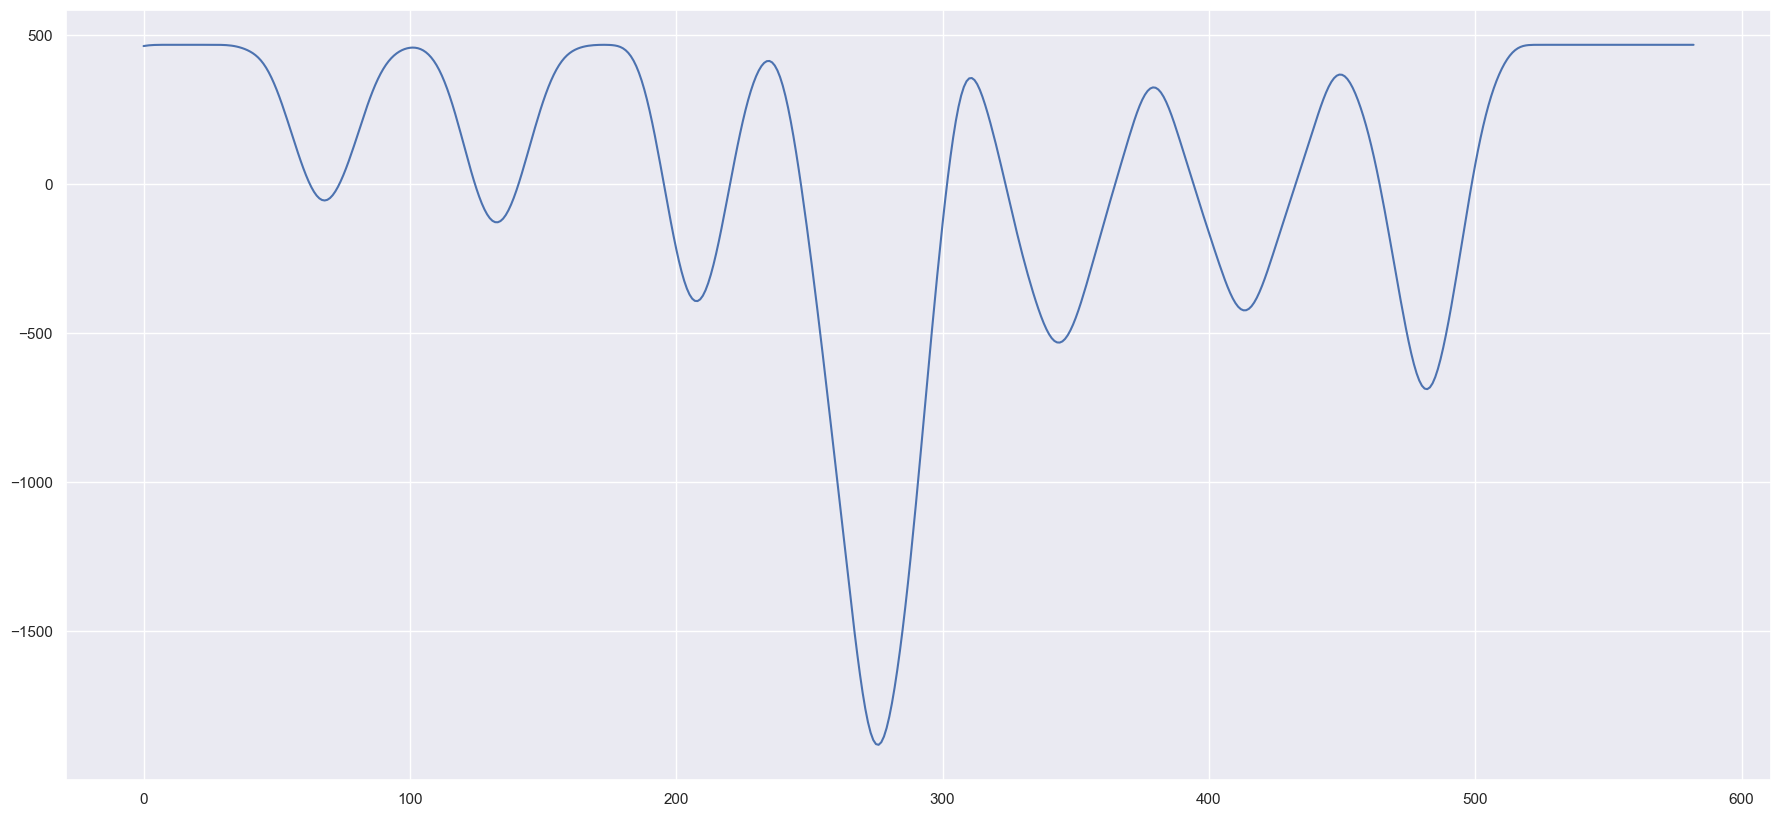

In [54]:
windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
smoothed = smooth(summ, 35)
plt.plot(smoothed)
plt.show()

In [55]:
from scipy.signal import argrelmin
mins = argrelmin(smoothed, order=2)
arr_mins = np.array(mins)

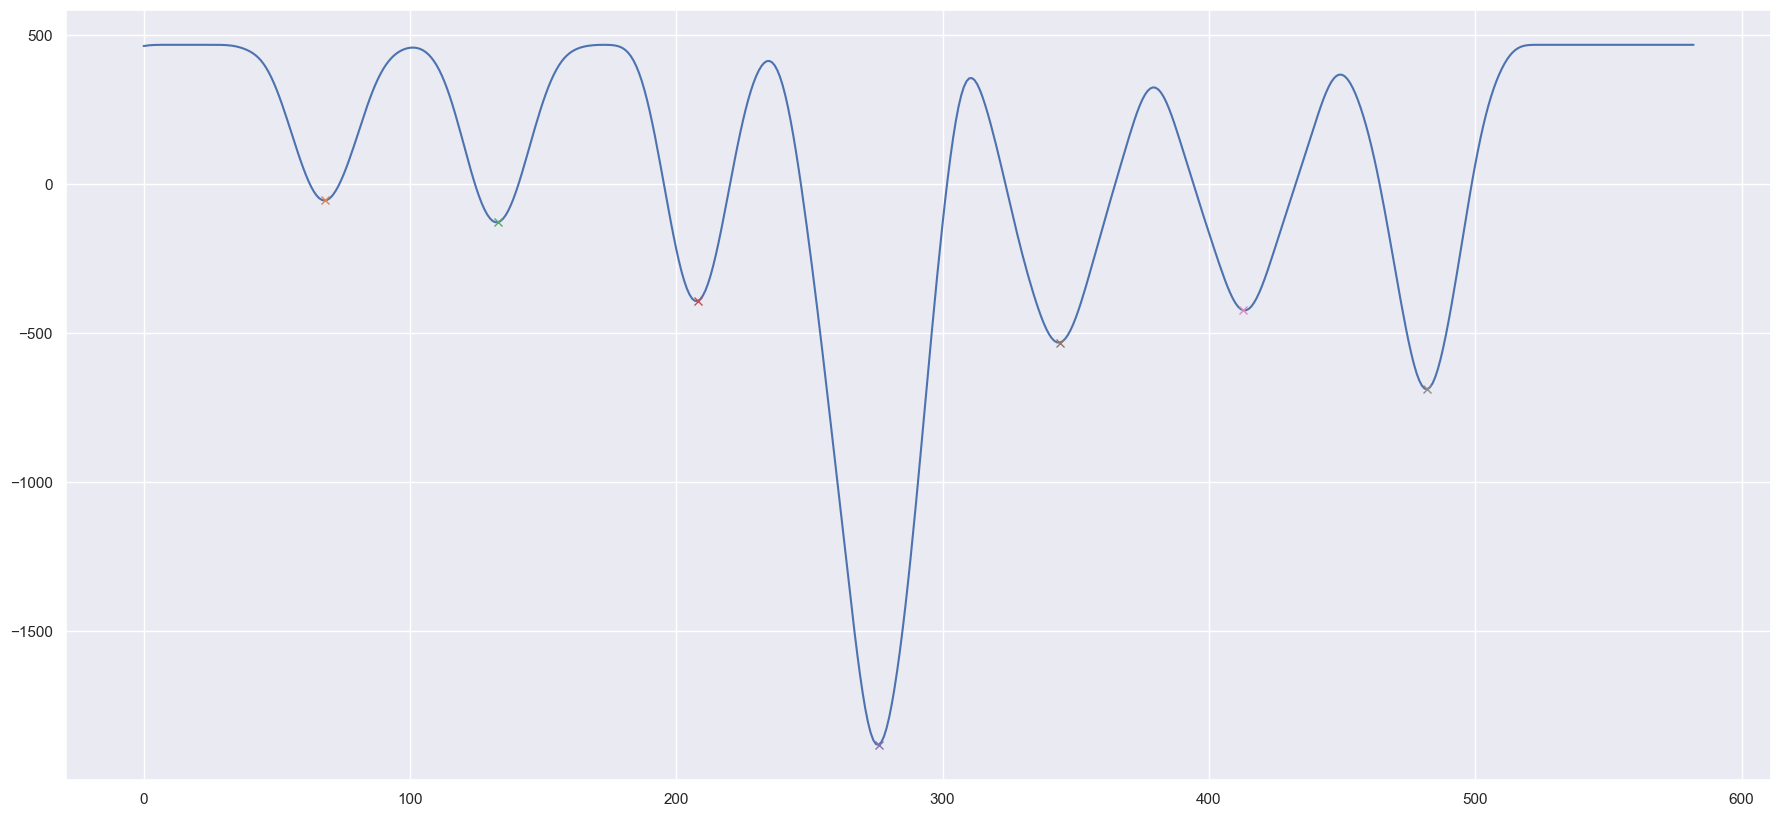

In [56]:
plt.plot(smoothed)
plt.plot(arr_mins, smoothed[arr_mins], "x")
plt.show()

In [57]:
img4.shape

(1050, 549)

In [58]:
type(arr_mins[0][0])

numpy.int64

In [59]:
def crop_text_to_lines(text, blanks):
    x1 = 0
    y = 0
    lines = []
    for i, blank in enumerate(blanks):
        x2 = blank
        print("x1=", x1, ", x2=", x2, ", Diff= ", x2-x1)
        line = text[:, x1:x2]
        lines.append(line)
        x1 = blank
    return lines
    

In [60]:
def display_lines(lines_arr, orient='vertical'):
    plt.figure(figsize=(30, 30))
    if not orient in ['vertical', 'horizontal']:
        raise ValueError("Orientation is on of 'vertical', 'horizontal', defaul = 'vertical'") 
    if orient == 'vertical': 
        for i, l in enumerate(lines_arr):
            line = l
            plt.subplot(2, 10, i+1)  # A grid of 2 rows x 10 columns
            plt.axis('off')
            plt.title("Line #{0}".format(i))
            _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    else:
            for i, l in enumerate(lines_arr):
                line = l
                plt.subplot(40, 1, i+1)  # A grid of 40 rows x 1 columns
                plt.axis('off')
                plt.title("Line #{0}".format(i))
                _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
                plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    

In [61]:
found_lines = crop_text_to_lines(img3, arr_mins[0])

x1= 0 , x2= 68 , Diff=  68
x1= 68 , x2= 133 , Diff=  65
x1= 133 , x2= 208 , Diff=  75
x1= 208 , x2= 276 , Diff=  68
x1= 276 , x2= 344 , Diff=  68
x1= 344 , x2= 413 , Diff=  69
x1= 413 , x2= 482 , Diff=  69


In [62]:
found_lines[2]

array([[160, 160, 160, ..., 160, 160, 160],
       [160, 160, 160, ..., 160, 160, 160],
       [160, 160, 160, ..., 160, 160, 160],
       ...,
       [160, 160, 160, ..., 160, 160, 160],
       [160, 160, 160, ..., 160, 160, 160],
       [160, 160, 160, ..., 160, 160, 160]], dtype=uint8)

In [71]:
sess = tf.Session()
found_lines_arr = []
with sess.as_default():
    for i in range(len(found_lines)-1):
        found_lines_arr.append(tf.expand_dims(found_lines[i], -1).eval())

AttributeError: module 'tensorflow' has no attribute 'Session'

In [63]:
import tensorflow as tf

found_lines_arr = []
for line in found_lines[:-1]:
    found_lines_arr.append(tf.expand_dims(line, -1).numpy())


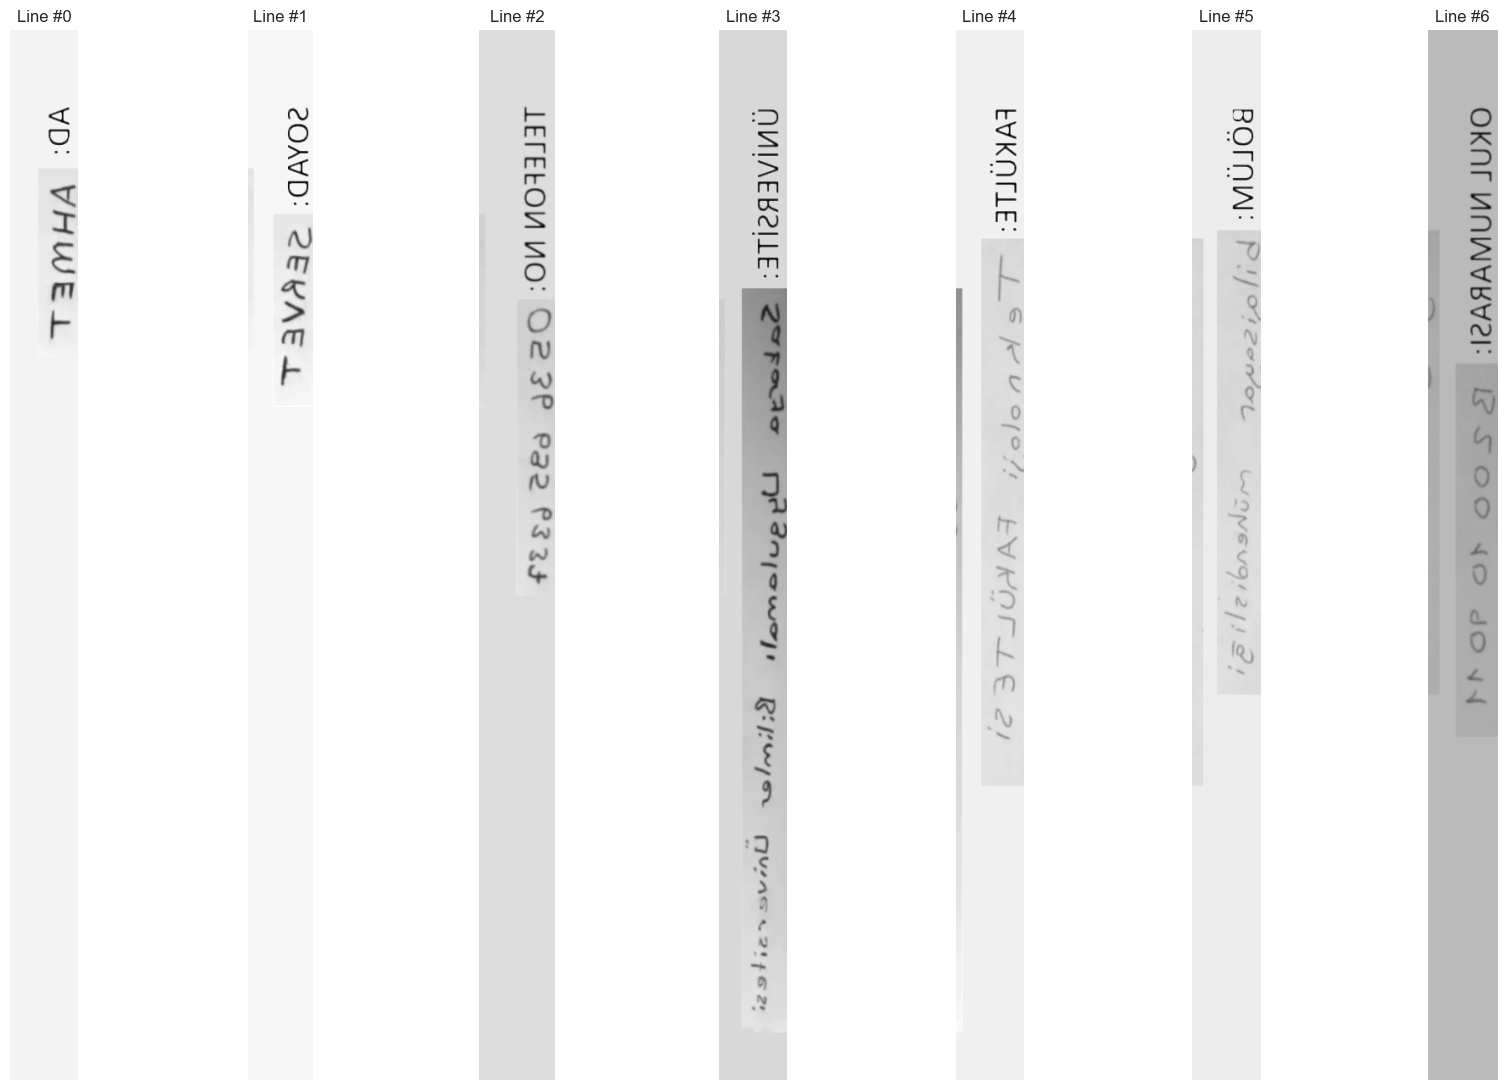

In [64]:
display_lines(found_lines)

In [65]:
def transpose_lines(lines):
    res = []
    for l in lines:
        line = np.transpose(l)
        res.append(line)
    return res
    

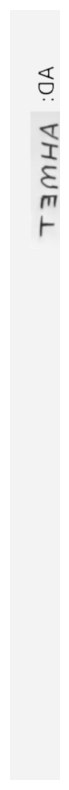

In [66]:
import matplotlib.pyplot as plt

def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

for line in found_lines:
    display_image(line)
    break

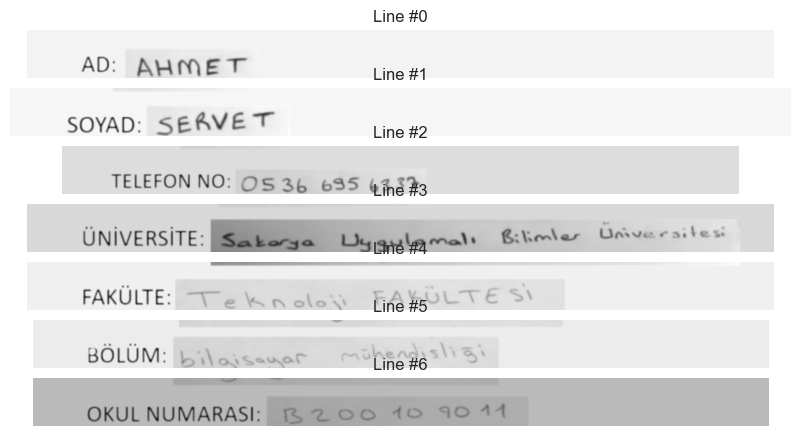

In [67]:
res_lines = transpose_lines(found_lines)
display_lines(res_lines, 'horizontal')

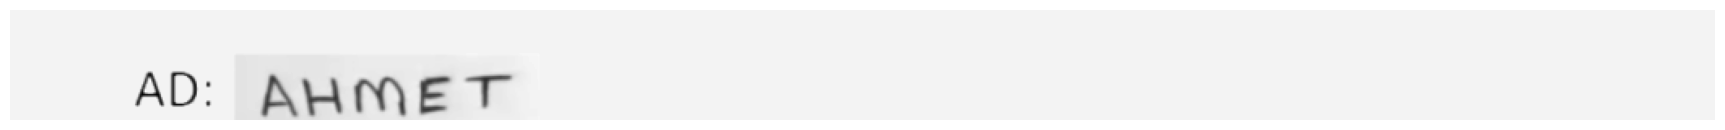

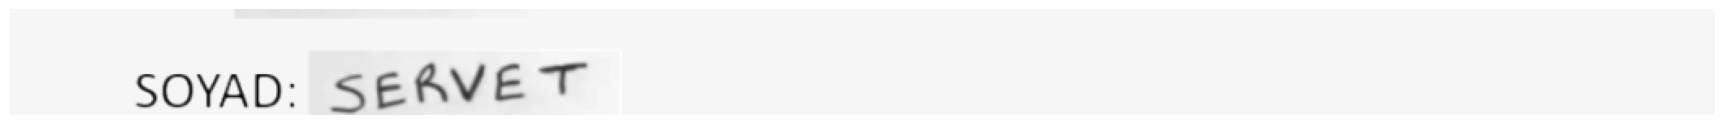

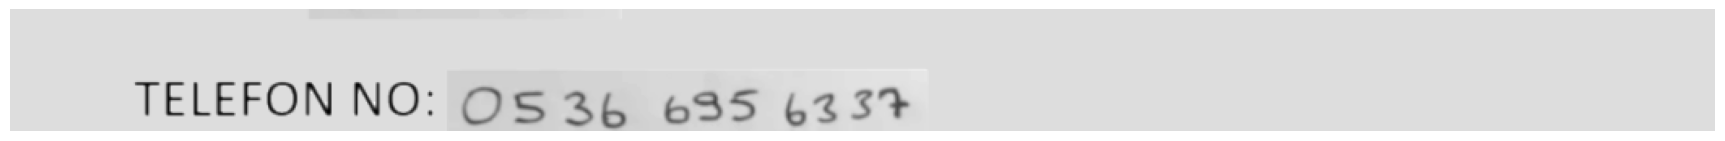

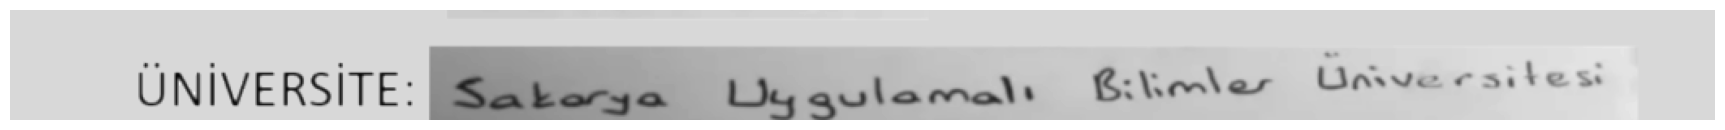

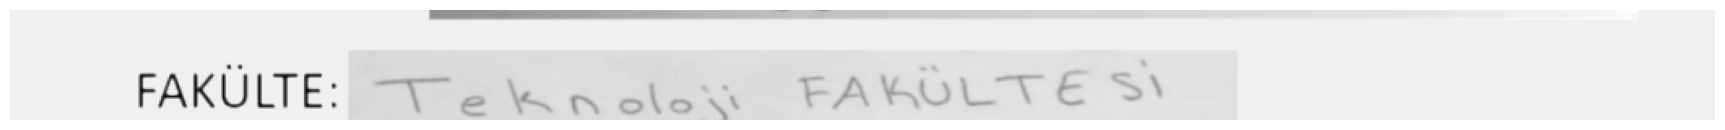

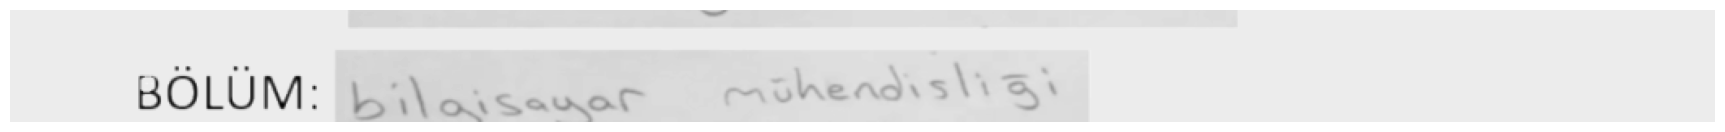

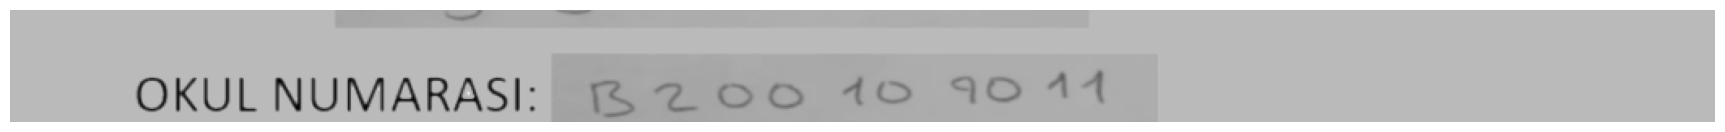

In [68]:
import matplotlib.pyplot as plt

def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

for line in res_lines:
    display_image(line)

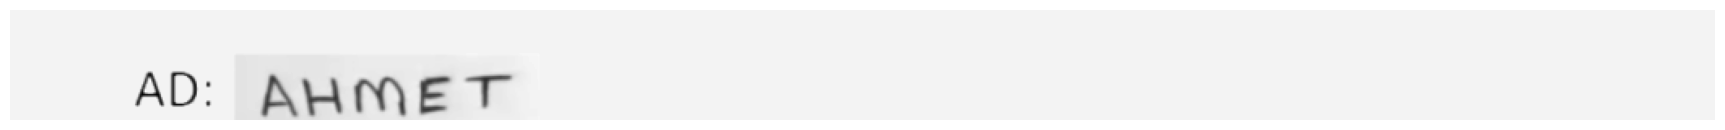

In [69]:
display_image(res_lines[0])